In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wandb
import datetime

In [2]:
entity = "evangeorgerex"
project_name = "fwal"
api = wandb.Api()

In [3]:
results_dir = r'/home/er647/projects/feature-wise-active-learning/results'

In [4]:
# we need all the run ids for fact
# then we need to get the best_mask_1_histogram or best_mask_1_parameters from the summary for each run
# this is a histogram. We can then concatenate the histograms. Ok so first we need to know what our datastructure should be for the histograms.

In [5]:
run_ids = [
    "bfi5l6qu" , # COIL20
    "ihpfigr4" , # COIL20
    "rhrqy9bb" , # COIL20
    "sj64pl05" , # Isolet
    "dtv0wjox" , # Isolet
    "gp378vp4" , # Isolet
    "vqcdnueq" , # PBMC
    '3e7c2ala' , # PBMC
    '9qx2b2na' , # PBMC
    "b8nrupvc" , # USPS
    "rcacu3yt" , # USPS
    "swbk9dsz" , # USPS
    "sawnisk5" , # finance
    "dqq6q5ej" , # finance
    "33iwvq59" , # finance
    "ko5c4p3v" , # madelon
    "h4m5vvcm" , # madelon
    "zyuohsyk" , # madelon
    "5le875vr" , # mice_protein
    "6utw0s44" , # mice_protein
    "r46u12zd" , # mice_protein
    "n0mcba2f" , # poly_binarised_decimalised_synth
    "94j8ch8b" , # poly_binarised_decimalised_synth
    "qskac7qn" , # poly_binarised_decimalised_synth
]

In [6]:
def get_mask_data(run_ids):
    """
    Returns a pandas DataFrame with columns 'mask_value' and 'dataset'.
    
    This function retrieves the mask data for each run specified by the given run_ids. The mask data is obtained from the 'best_mask_1_parameters' key in the summary. The mask data is a list of floats, which represents the mask values. Additionally, the function also retrieves the dataset information from the configuration.
    
    Args:
        run_ids (list): A list of run IDs for which the mask data needs to be retrieved.
        
    Returns:
        pandas.DataFrame: A DataFrame containing the mask values and dataset information.
    """
    
    # Implementation goes here
    mask_data = []
    for run_id in run_ids:
        run = api.run(f"{entity}/{project_name}/{run_id}")
        mask_0 = run.summary['best_mask_0_parameters']
        mask = run.summary['best_mask_1_parameters']
        dataset = run.config['dataset']
        for i in range(len(mask)):
            mask_data.append({'mask_value': mask[i], 'mask_0_value': mask_0[i], 'dataset': dataset})
    return pd.DataFrame(mask_data)



In [31]:
# mask can be one of 'mask_value' or 'mask_0_value'
def plot_hists(df: pd.DataFrame, how="logits", save=False,threshold_line=None, mask_0=False):
    """
    Plot histograms of mask values for different datasets.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - how (str): The type of mask values to plot. Must be one of 'logits' or 'probability'. Default is 'logits'.
    - save (bool): Whether to save the plot as an image file. Default is False.
    - bins (int): The number of bins to use for the histograms. Default is 100.
    - threshold_line (float): The threshold value to plot as a vertical line. Default is None.
    - mask_0 (bool): Whether to use the 'mask_0_value' column instead of 'mask_value'. Default is False.

    Returns:
    None
    """
    if how == "logits":
        x = 'mask_value' if not mask_0 else 'mask_0_value'
        x_label = 'Mask Value'
    elif how == "probability":
        x = 'mask_value_probability' if not mask_0 else 'mask_0_value_probability'
        x_label = 'Mask Probability'
    else:
        raise ValueError("how must be one of 'logits' or 'probability'")

    datasets = ['USPS', 'mice_protein', 'COIL20', 'Isolet', 'PBMC', 'finance', 'madelon']

    # Number of unique datasets
    num_datasets = df['dataset'].nunique()

    # Create a figure with 2 rows and 4 columns of subplots
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10), sharex=True)

    # Flatten the axes array for easier indexing
    axes = axes.flatten()

    title_map = {
        'USPS': 'USPS',
        'mice_protein': 'Mice Protein',
        'Isolet': 'Isolet',
        'madelon': 'Madelon',
        'COIL20': 'COIL20',
        'PBMC': 'PBMC',
        'finance': 'Finance'
    }
    bin_map = {
        'USPS': 75,
        'mice_protein': 40,
        'Isolet': 500,
        'madelon': 250,
        'COIL20': 500,
        'PBMC': 10000,
        'finance': 100
    }
    
    
    # Font size settings
    axis_title_font_size = 24
    axis_label_font_size = 24
    
    
    # Loop over each group and plot
    for idx, dataset in enumerate(datasets):
        group = df[df['dataset'] == dataset]
        ax = axes[idx]
        sns.histplot(data=group, x=x, bins=bin_map[dataset], kde=True, ax=ax, color='black', edgecolor='black')
        ax.set_title(title_map[dataset], fontsize=axis_title_font_size)
        ax.set_xlabel(x_label, fontsize=axis_label_font_size)
        ax.set_ylabel('Frequency', fontsize=axis_label_font_size)
        
        if idx in [0,1,2]:
            ax.set_xlabel('')
        if idx in [1,2,3,5,6]:
            ax.set_ylabel('')
            
        if threshold_line is not None:
            ax.axvline(x=threshold_line, color='red', linestyle='--')

    # Turn off unused subplots if the number of datasets is less than the number of subplots
    for ax in axes[num_datasets:]:
        ax.axis('off')

    # Adjust layout to prevent overlap
    plt.tight_layout()

    if save:
        plt.savefig(f'{results_dir}/{x}_histograms.pdf')
    plt.show()


In [32]:
df = get_mask_data(run_ids)
df = df[df['dataset'] !=  'poly_binarised_decimalised_synth']

In [33]:
# Define the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Apply the sigmoid function to the 'mask_value' column and create a new 'probability' column
df['mask_value_probability'] = df['mask_value'].apply(sigmoid)
df['mask_0_value_probability'] = df['mask_0_value'].apply(sigmoid)


In [34]:
df.head()

,mask_value,mask_0_value,dataset,mask_value_probability,mask_0_value_probability
0,-1.481845,-2.756537,COIL20,0.185149,0.059719
1,0.535153,0.315952,COIL20,0.630684,0.578337
2,0.905044,-1.425529,COIL20,0.711985,0.193796
3,-1.211367,-2.589063,COIL20,0.229459,0.069846
4,-1.129280,-2.840790,COIL20,0.244294,0.055159


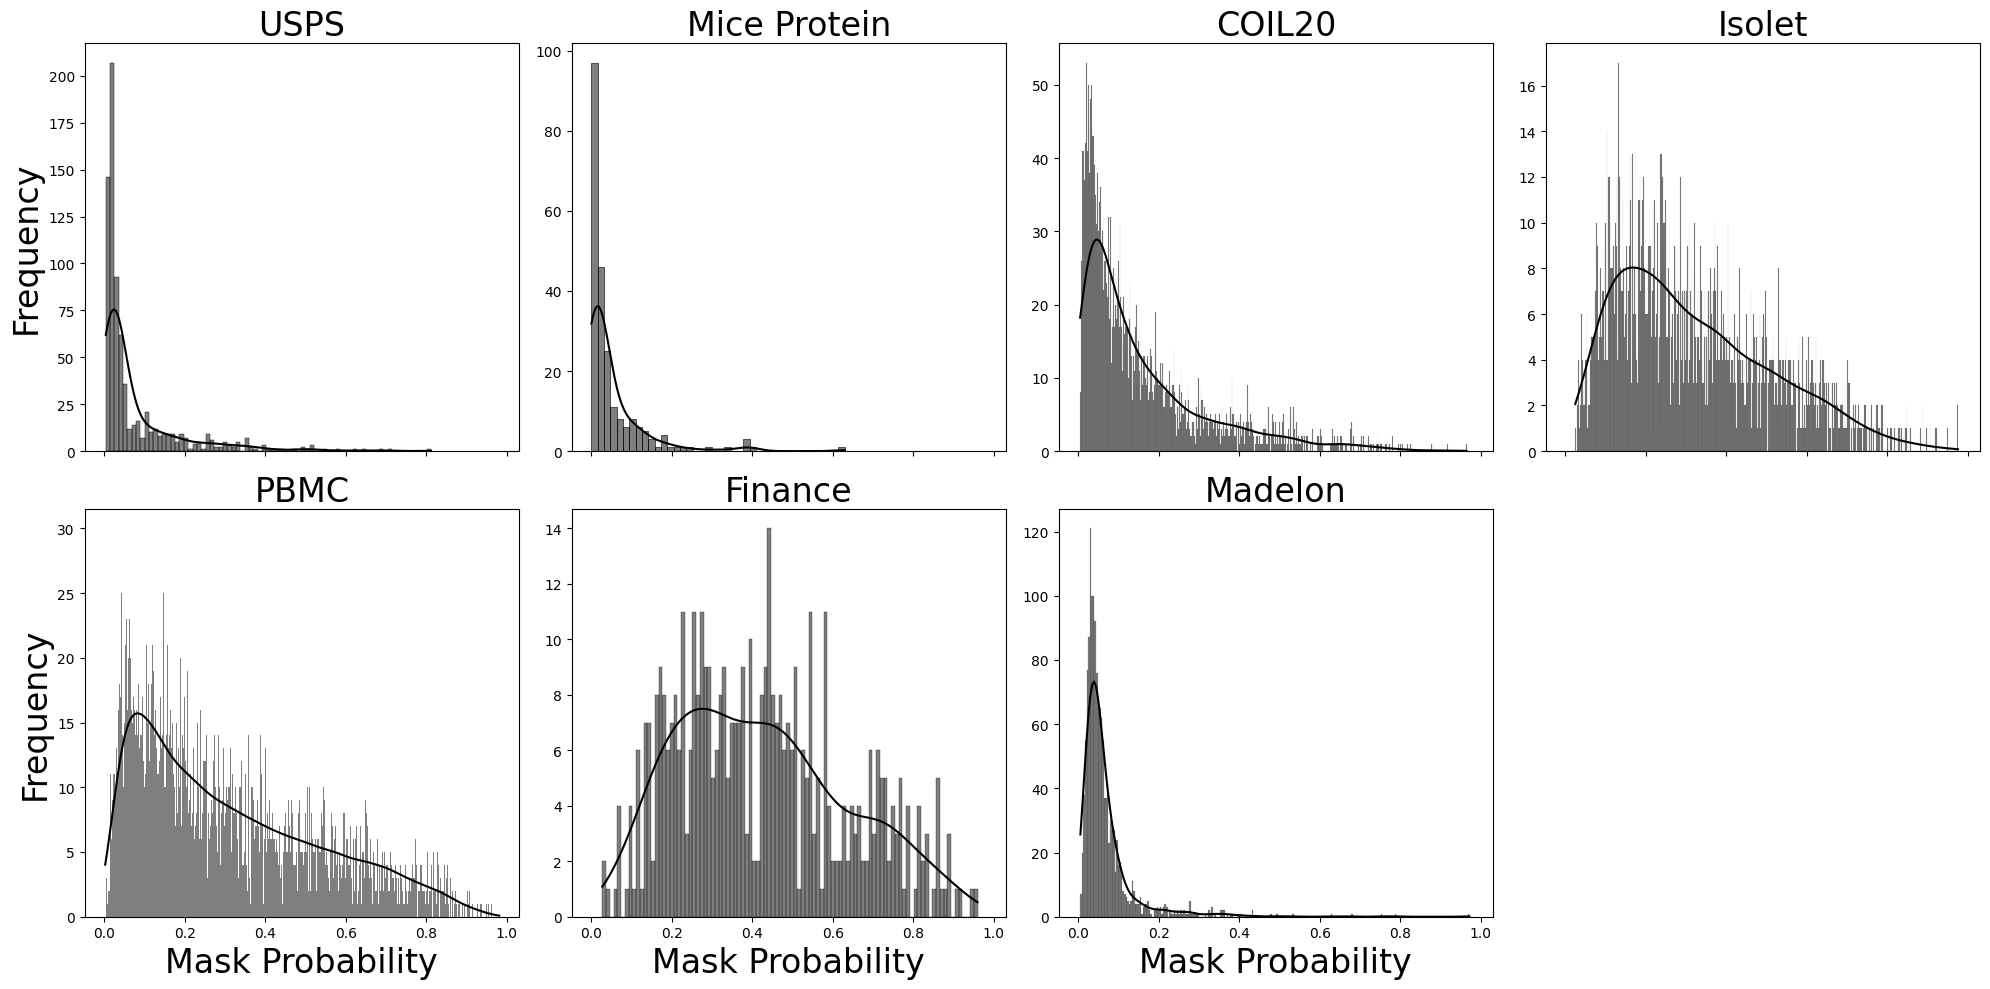

In [37]:
plot_hists(df, how = "probability", save=True, mask_0=True)

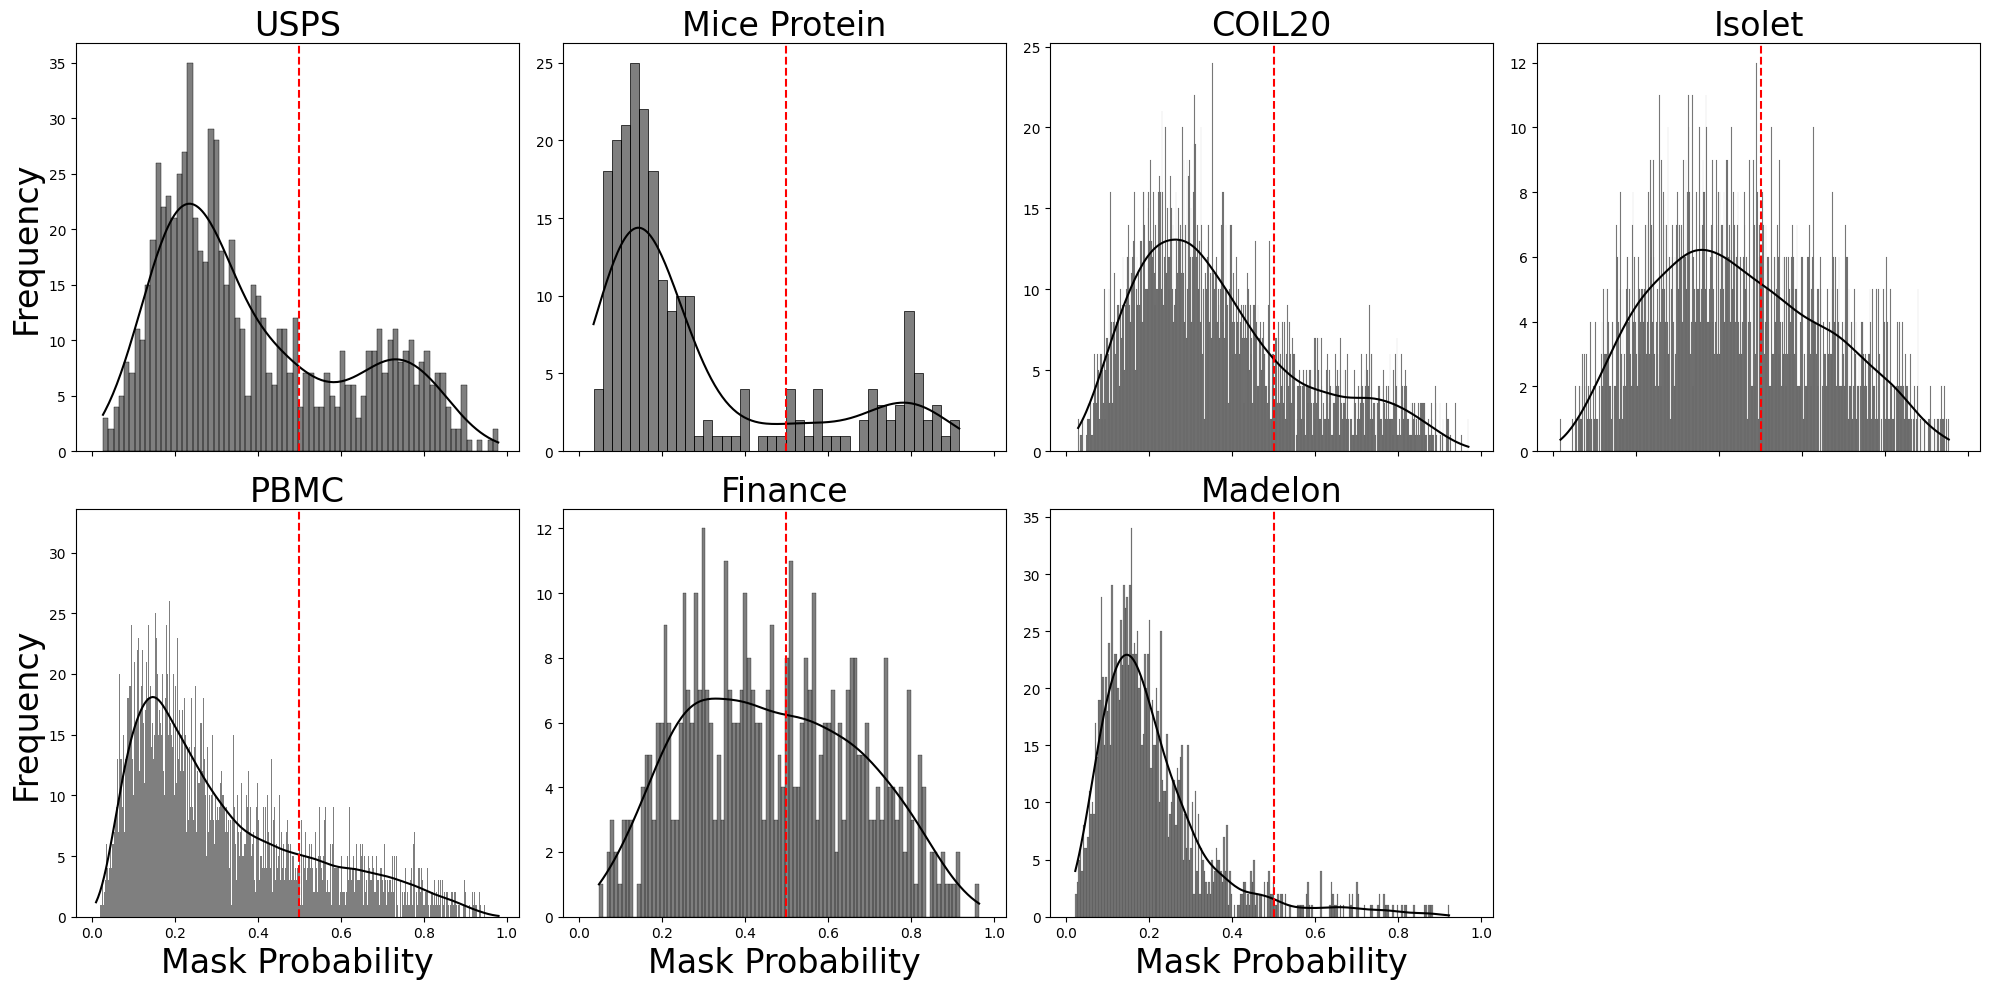

In [38]:
plot_hists(df, how = "probability", save=True, mask_0=False, threshold_line=0.5)


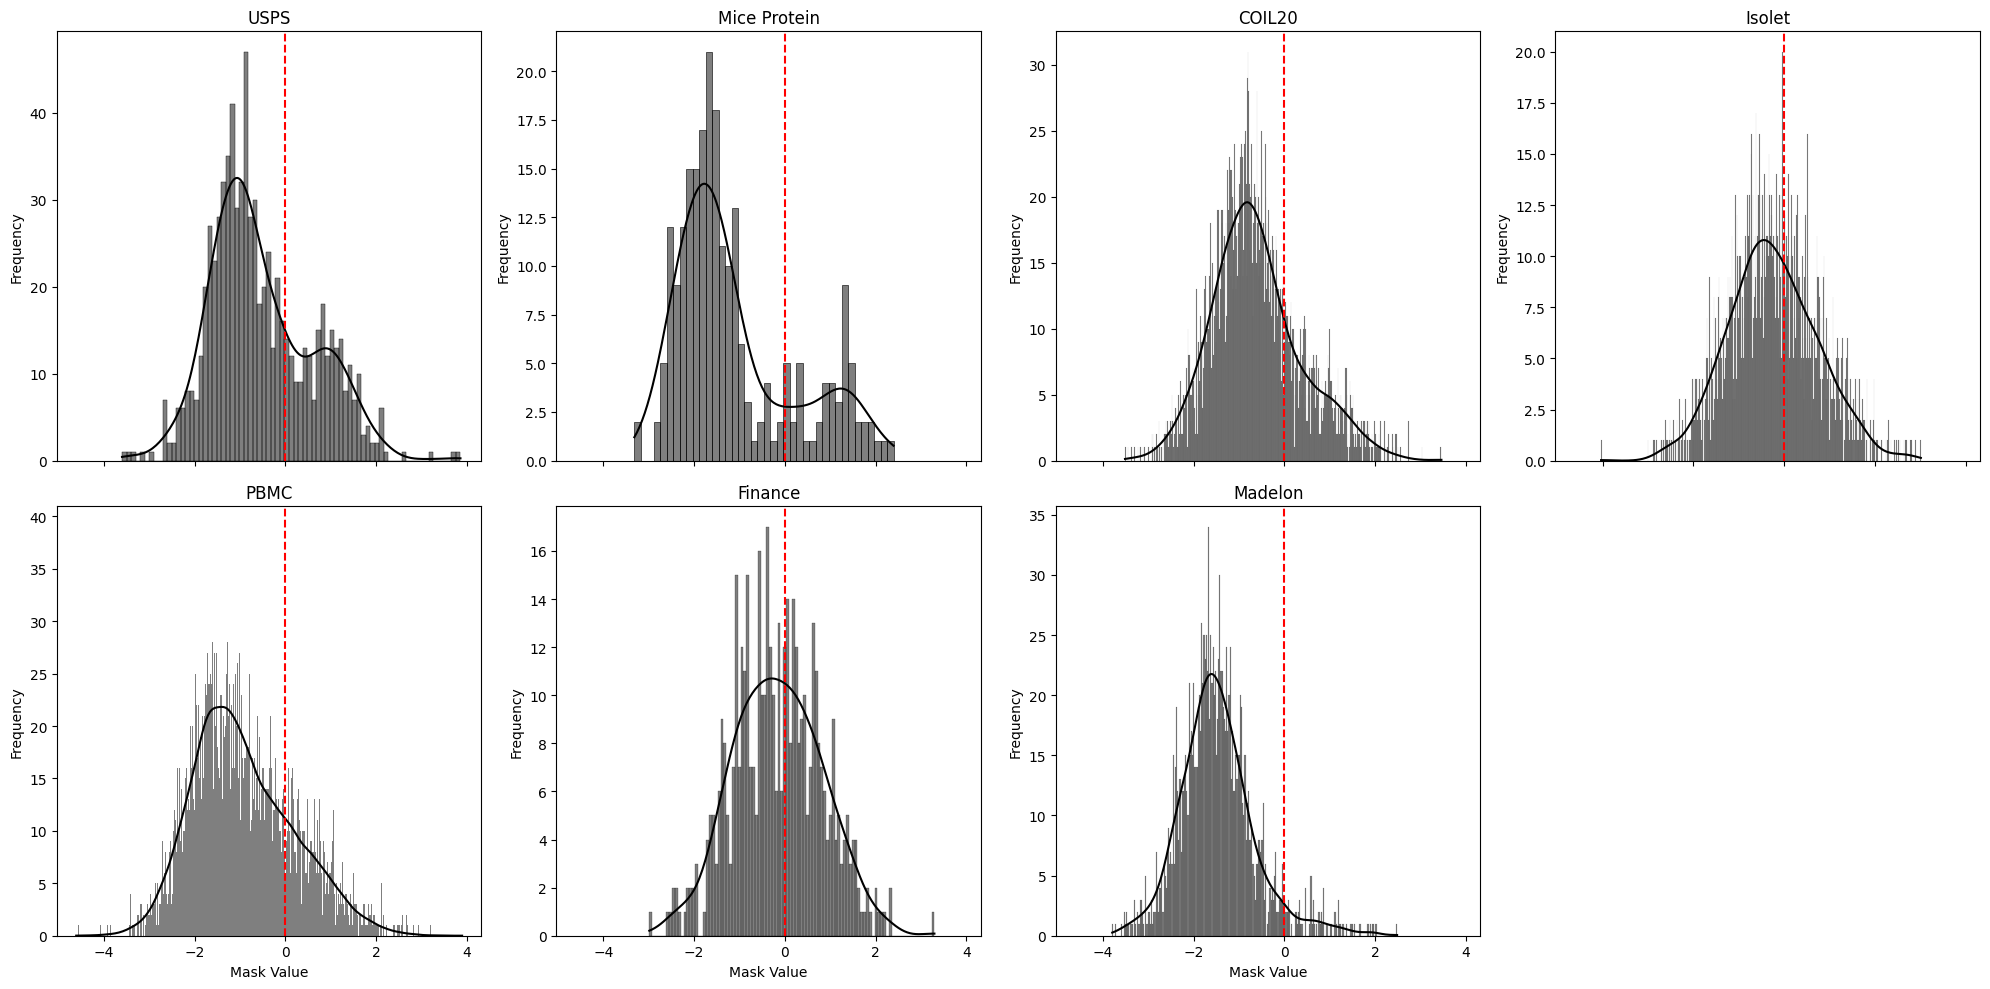

In [46]:
plot_hists(df, save=True, bins=50, threshold_line=0)

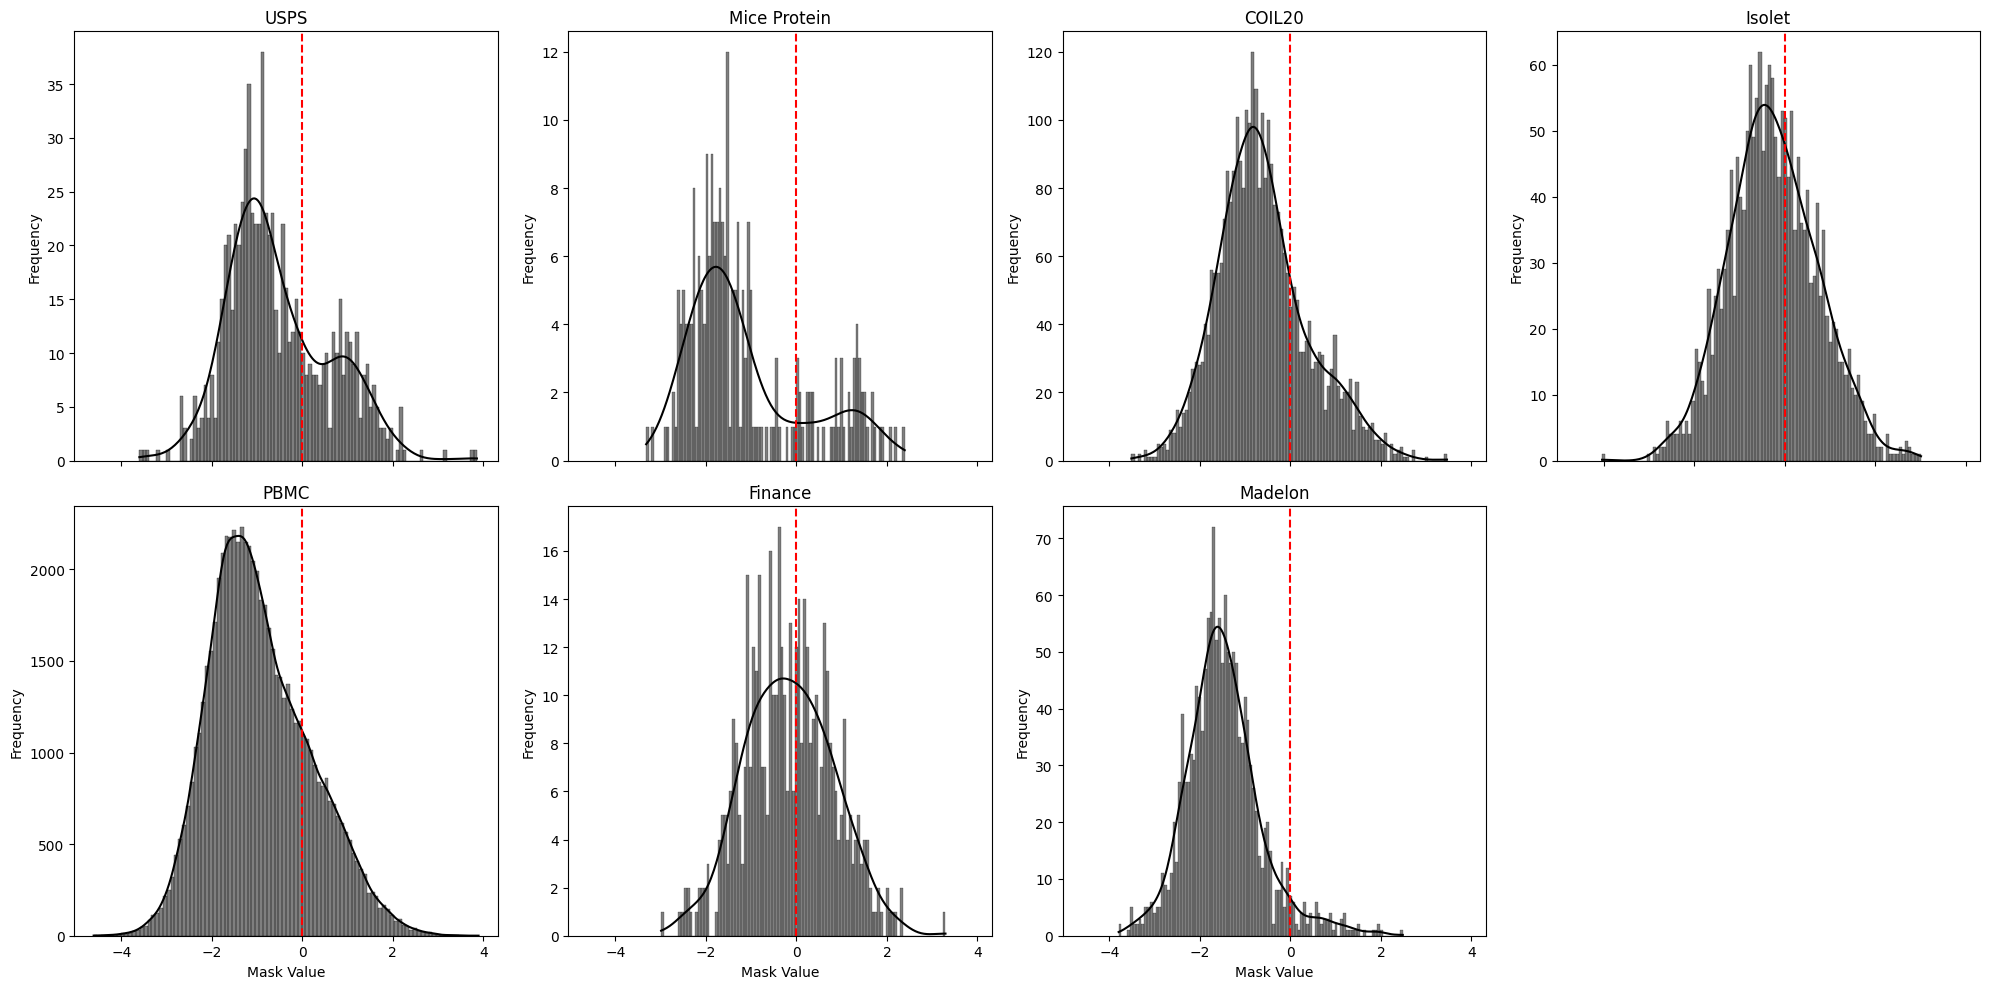

In [36]:
plot_hists(df, save=False, bins=100, threshold_line=0)


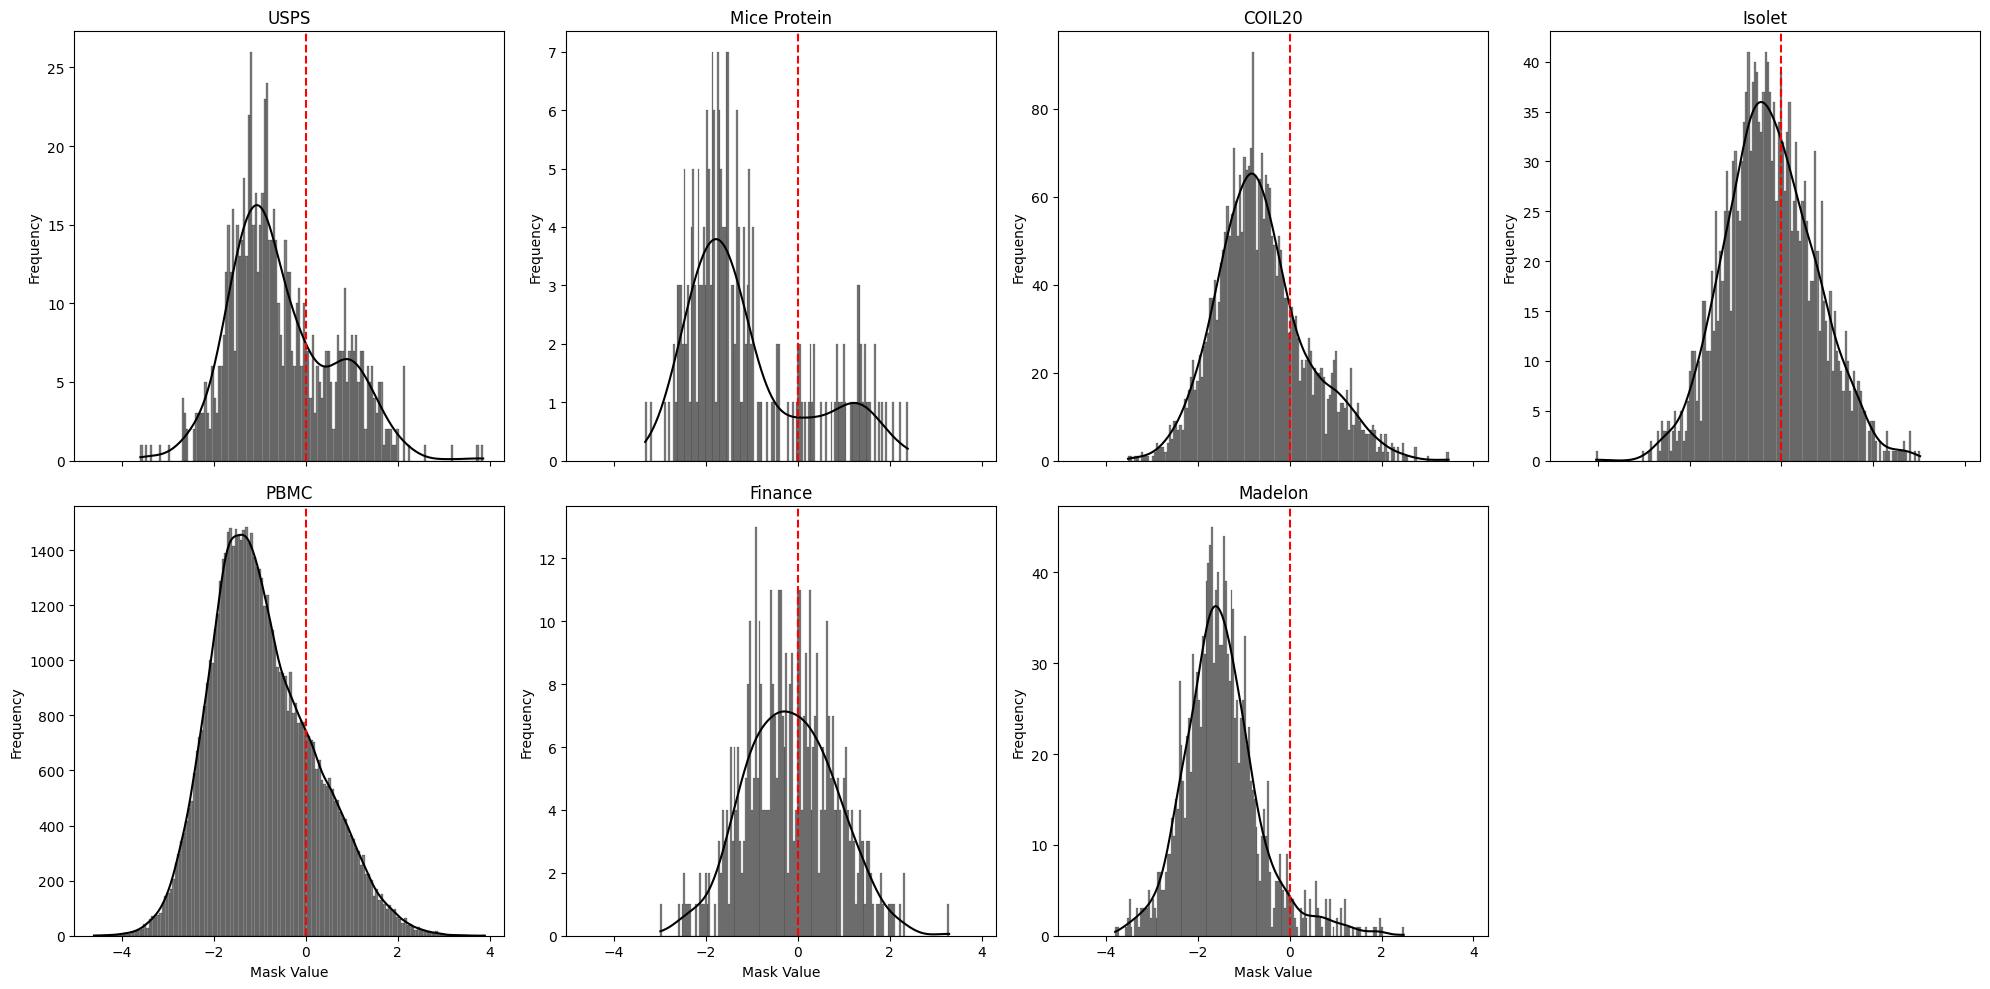

In [37]:
plot_hists(df, save=False, bins=150, threshold_line=0)


In [7]:
def combine_histograms(histograms):
    # Determine the overall range of bins
    min_bin = min(hist['bins'][0] for hist in histograms)
    max_bin = max(hist['bins'][-1] for hist in histograms)
    
    # Create a new set of bins, here using the minimum and maximum with a dynamic bin width based on the input histograms
    # For simplicity, we'll use a fixed number of bins, but this could be adapted
    num_bins = 50
    new_bins = np.linspace(min_bin, max_bin, num_bins)
    
    # Initialize an array to hold the combined counts
    combined_counts = np.zeros(len(new_bins) - 1)
    
    # Process each histogram
    for hist in histograms:
        # For each old bin, find the closest new bin and add the counts
        for i, count in enumerate(hist['values']):
            # Find the center of the current old bin
            old_bin_center = (hist['bins'][i] + hist['bins'][i + 1]) / 2
            
            # Find the index of the closest new bin
            new_bin_index = np.argmin(np.abs(new_bins - old_bin_center))
            
            # Check if this assignment overshoots the array bounds
            if new_bin_index == len(combined_counts):
                new_bin_index -= 1
            
            # Add the count to the closest new bin
            combined_counts[new_bin_index] += count
    
    return new_bins, combined_counts

from itertools import combinations

def hamming_distance(s1, s2):
    """Calculate the Hamming distance between two strings."""
    assert len(s1) == len(s2), "Strings must be of the same length"
    return sum(el1 != el2 for el1, el2 in zip(s1, s2))

def normalized_average_hamming_distance(strings, inverse=False):
    """Calculate the normalized average Hamming distance for a list of strings."""
    if len(strings) < 2:
        return 0  # No distance if there's only one string
    
    distances = [hamming_distance(s1, s2) for s1, s2 in combinations(strings, 2)]
    if inverse:
        zero_counts = [s.count("1") for s in strings]
    else:
        zero_counts = [s.count("0") for s in strings]
    average_distance = sum(distances) / len(distances)
    return average_distance / sum(zero_counts) # Normalize by average number of masked features

def get_agreement(mask_dict, inverse=False):
    # Get the agreement between the masks
    df_dict = {'dataset': [], 'normalized_distances': [], 'avg_num_masked_features': [], 'num_features': []}
    for key, value in mask_dict.items():
        df_dict['dataset'].append(key)
        df_dict['normalized_distances'].append(normalized_average_hamming_distance(value, inverse=inverse))
        if inverse:
            df_dict['avg_num_masked_features'].append(np.mean([s.count("1") for s in value]))
        else:
            df_dict['avg_num_masked_features'].append(np.mean([s.count("0") for s in value]))
        df_dict['num_features'].append(len(value[0]))
    
    # Convert to DataFrame
    df = pd.DataFrame.from_dict(df_dict)

    # Subtract each value from 1
    df['Mask stability'] = 1 - df['normalized_distances']
    df.drop(columns=['normalized_distances'], inplace=True)
    
    df['masked_feat_fraction'] = df['avg_num_masked_features'] / df['num_features']

    # Pretty print the DataFrame
    return df.style.set_table_styles(
        [{'selector': 'th', 'props': [('background', '#606060'), ('color', 'white')]}]
    ).set_caption("Mask stability across multiple seeds")



In [8]:
get_agreement(mask_dict)

,dataset,avg_num_masked_features,num_features,Mask stability,masked_feat_fraction
0,finance,117.333333,154,0.835227,0.761905
1,USPS,188.000000,256,0.813239,0.734375
2,madelon,475.666667,500,0.971969,0.951333
3,Isolet,518.000000,617,0.897469,0.839546
4,COIL20,866.000000,1024,0.898127,0.845703
5,mice_protein,47.333333,77,0.821596,0.614719
6,poly_binarised_decimalised_synth,8.000000,10,0.833333,0.800000


In [9]:
mask_dict_1 = {key: val for key, val in mask_dict.items() if key != 'poly_binarised_decimalised_synth'}

get_agreement(mask_dict_1, inverse=True)


,dataset,avg_num_masked_features,num_features,Mask stability,masked_feat_fraction
0,finance,36.666667,154,0.472727,0.238095
1,USPS,68.000000,256,0.483660,0.265625
2,madelon,24.333333,500,0.452055,0.048667
3,Isolet,99.000000,617,0.463524,0.160454
4,COIL20,158.000000,1024,0.441632,0.154297
5,mice_protein,29.666667,77,0.715356,0.385281


In [10]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def plot_histograms(hist_dict, threshold_line=None, sigmoid_x=False):
    # Determine the layout of the subplots
    nrows = int(len(hist_dict)**0.5)  # Square root of the number of datasets for rows
    ncols = int(len(hist_dict) / nrows) + (len(hist_dict) % nrows > 0)  # Adjust columns accordingly

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*4))  # Adjust figsize for landscape layout
    fig.tight_layout(pad=3.0)  # Add some padding between plots

    for ax, (dataset, histograms) in zip(axs.flatten(), hist_dict.items()):
        try:
            bins, values = combine_histograms(histograms)
        except Exception as e:
            print(f"Error combining histograms for {dataset}: {e}")
            continue
        
        # Normalize the values by number of histograms
        values /= len(histograms)
        
        # Apply sigmoid transformation if needed
        if sigmoid_x:
            # Use original bins to calculate values at transformed bins
            transformed_bins = sigmoid(bins)
            bin_edges = np.histogram_bin_edges(bins, bins=transformed_bins)
            values, _ = np.histogram(bins[:-1], bins=bin_edges, weights=values)
            bin_centers = (transformed_bins[:-1] + transformed_bins[1:]) / 2
            bin_widths = np.diff(transformed_bins)
        else:
            # Calculate bin widths and bin centers as usual
            bin_widths = np.diff(bins)
            bin_centers = (bins[:-1] + bins[1:]) / 2

        # Plotting on the specific subplot axis
        ax.bar(bin_centers, values, width=bin_widths, align='center', edgecolor='black')
        ax.set_xlabel('Bin (Transformed)' if sigmoid_x else 'Bin')
        ax.set_ylabel('Count')
        if threshold_line is not None:
            # Transform threshold line if sigmoid is applied
            transformed_threshold = sigmoid(threshold_line) if sigmoid_x else threshold_line
            ax.axvline(x=transformed_threshold, color='red', linestyle='--')
        ax.set_title(f'{dataset} Histogram')

    # Adjust if the number of datasets is not a perfect square to hide empty subplots
    for ax in axs.flatten()[len(hist_dict):]:
        ax.set_visible(False)

    plt.show()


In [15]:
y = 0.1
x = np.log(y / (1 - y))
x

-2.197224577336219

In [17]:
sigmoid = lambda x  : 1 / (1 + np.exp(-x))
for val in [-5, -2, -1, 0, 1, 2, 5]:
    print(f"sigmoid({val}) = {sigmoid(val)}")

sigmoid(-5) = 0.0066928509242848554
sigmoid(-2) = 0.11920292202211755
sigmoid(-1) = 0.2689414213699951
sigmoid(0) = 0.5
sigmoid(1) = 0.7310585786300049
sigmoid(2) = 0.8807970779778825
sigmoid(5) = 0.9933071490757153


Error combining histograms for poly_binarised_decimalised_synth: list indices must be integers or slices, not str


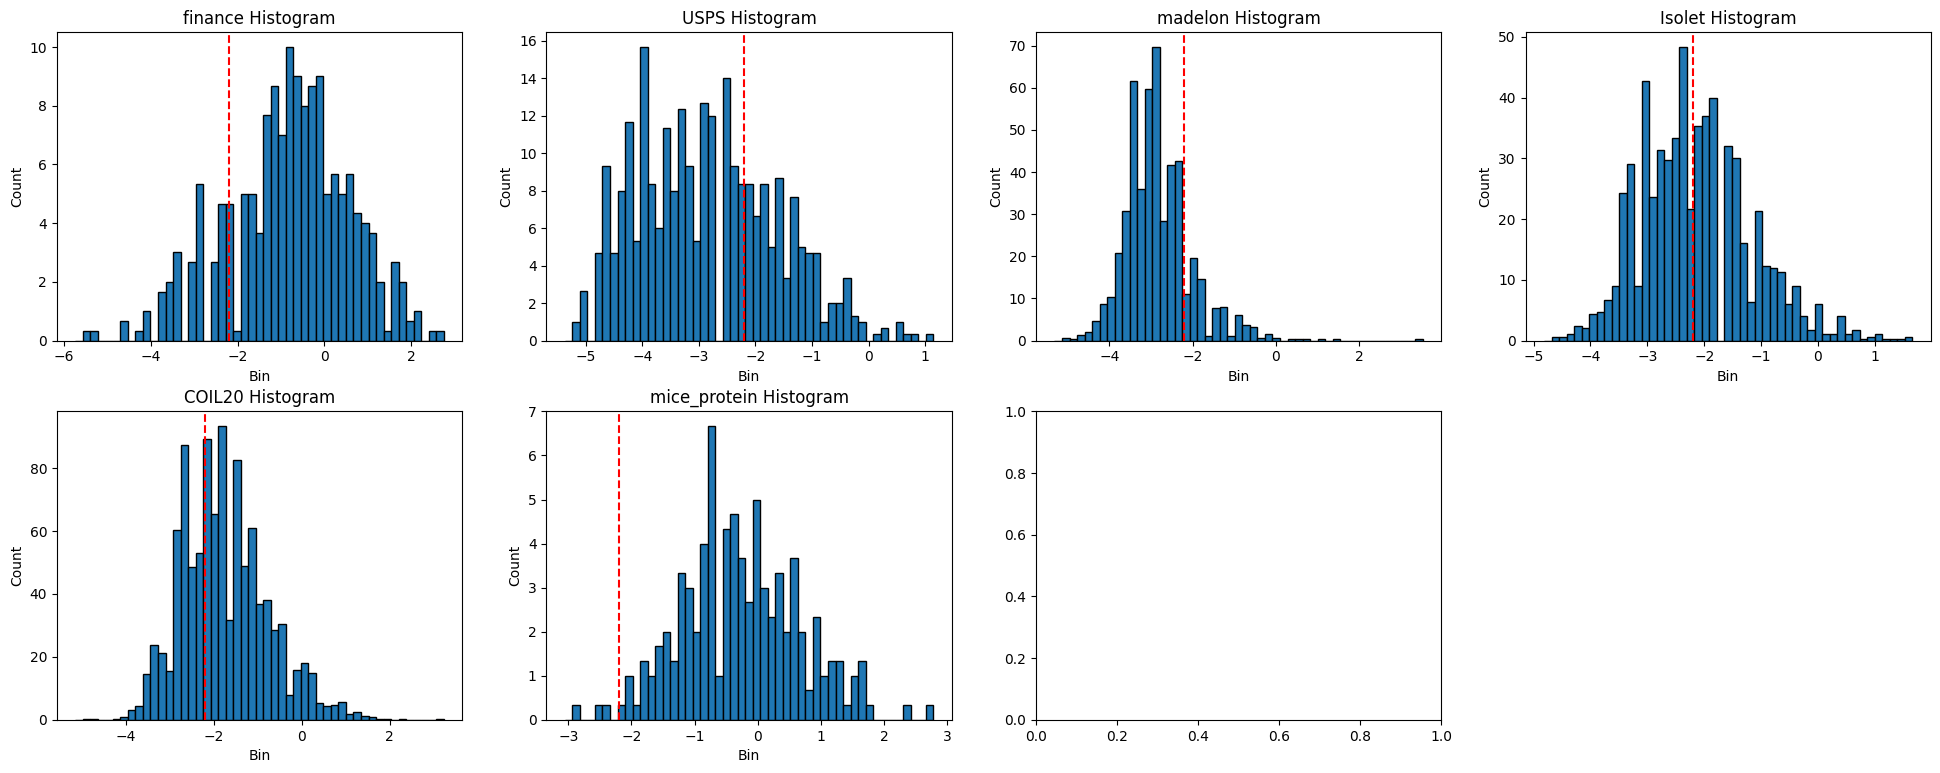

In [16]:
plot_histograms(hist_0_dict, threshold_line=-2.197224577336219)

Error combining histograms for poly_binarised_decimalised_synth: list indices must be integers or slices, not str


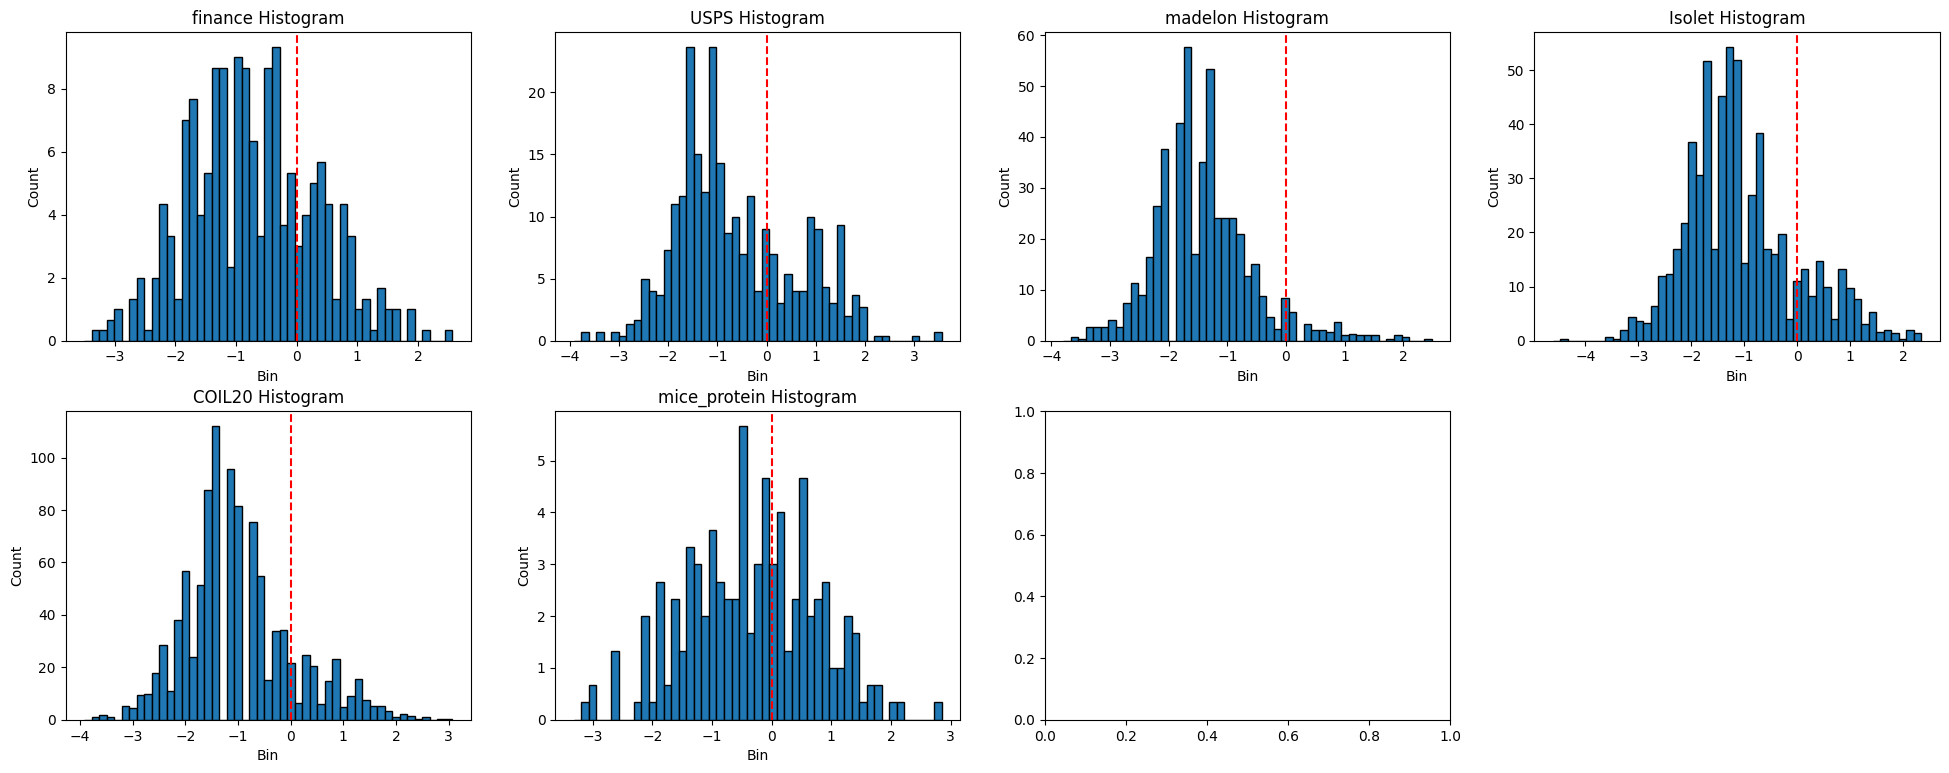

In [12]:
plot_histograms(hist_1_dict, threshold_line=0)

In [13]:
hist = run.summary['best_mask_parameters']

KeyError: 'best_mask_parameters'

In [ ]:
a = np.array(hist['values'])
b = a
np.vstack((a,b)).mean(axis=0).shape

(32,)

In [ ]:
hist

{'values': [1, 0, 1, 0, 0, 0, 0, 1, 0, 2, 3, 4, 3, 10, 18, 15, 37, 32, 40, 50, 59, 59, 44, 30, 32, 21, 11, 14, 2, 4, 5, 2], 'bins': [-2.3778932094573975, -2.191999673843384, -2.006105899810791, -1.8202123641967773, -1.6343187093734741, -1.448425054550171, -1.2625313997268677, -1.0766377449035645, -0.890744149684906, -0.7048504948616028, -0.5189568996429443, -0.3330632448196411, -0.14716961979866028, 0.038724012672901154, 0.22461764514446259, 0.4105112850666046, 0.5964049100875854, 0.7822985649108887, 0.9681921601295471, 1.1540857553482056, 1.3399794101715088, 1.525873064994812, 1.7117667198181152, 1.8976603746414185, 2.0835540294647217, 2.2694475650787354, 2.455341339111328, 2.641234874725342, 2.8271284103393555, 3.0130221843719482, 3.198915719985962, 3.3848094940185547, 3.5707030296325684], '_type': 'histogram'}

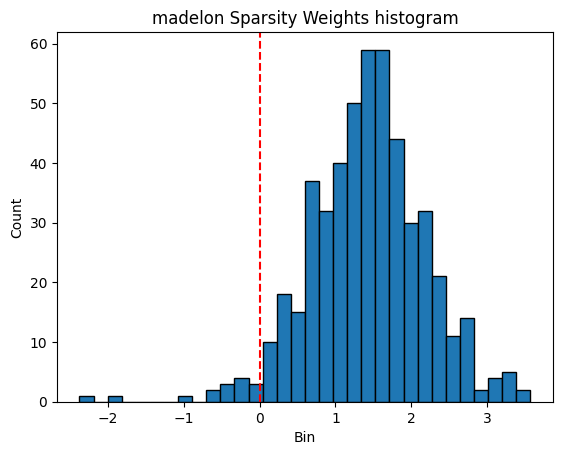

In [ ]:

# Histogram data
values = hist['values']
bins = hist['bins']

# Calculate bin widths and bin centers
bin_widths = [j - i for i, j in zip(bins[:-1], bins[1:])]
bin_centers = [(i + j) / 2 for i, j in zip(bins[:-1], bins[1:])]

# Plotting
plt.bar(bin_centers, values, width=bin_widths, align='center', edgecolor='black')
plt.xlabel('Bin')
plt.ylabel('Count')
plt.axvline(x=0, color='red', linestyle='--')

plt.title(f'{dataset} Sparsity Weights histogram')
plt.show()


In [ ]:
# Initialize a list to store data
data = []

# Iterate over each run and fetch the required data
for run in sweep.runs:
    config = run.config
    summary_metrics = run.summary
    # You might need to adjust the key names based on your actual data
    try:
        data.append({
            'dataset': config['dataset'],  
            'seed_model_init': config['seed_model_init'], 
            # Add other hyperparameters here as needed
            'normalize_reconstruction': config['normalize_reconstruction'],  
            'balanced_accuracy': summary_metrics['bestmodel_valid/balanced_accuracy'],  # Adjust based on your summary metrics
            # Include other config elements as necessary
        })
    except:
        print(f"Run {run.id} failed")

# Convert the list to a DataFrame
df = pd.DataFrame(data)

df = df[df['dataset'] != 'poly_binarised_decimalised_mod10_synth'] # excliude this dataset

# Group by dataset and other relevant hyperparameters (excluding seed), and calculate the mean of balanced_accuracy across seeds
grouped_df = df.groupby(['dataset', 
                         'normalize_reconstruction'  # Add other hyperparameters here, except 'seed'
                        ]).agg({'balanced_accuracy': 'mean'}).reset_index()

# Now, find the entry with the maximum 'balanced_accuracy' for each 'dataset'
result_df = grouped_df.loc[grouped_df.groupby('dataset')['balanced_accuracy'].idxmax()]

# Display the resulting DataFrame
print(result_df)


Run x5mlx25b failed
Run 6y520ck9 failed
Run fa1xfouk failed
Run 1691mmmr failed
             dataset normalize_reconstruction  balanced_accuracy
0              MNIST  num_non_masked_features           0.980751
2  simple_trig_synth             num_features           0.979334


In [ ]:
print(grouped_df)

             dataset normalize_reconstruction  balanced_accuracy
0              MNIST  num_non_masked_features           0.980751
1  simple_trig_synth                     None           0.975825
2  simple_trig_synth             num_features           0.979334
3  simple_trig_synth  num_non_masked_features           0.978480
